In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
from model import Net
from utils import train, test, get_dataset_stats, plot_grid, Cifar10Dataset, augmentation, plot_misclassified, plot_curves
%matplotlib inline

In [2]:
cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
imgs = [item[0] for item in cifar_trainset]
labels = [item[1] for item in cifar_trainset]

mu, sigma = get_dataset_stats(imgs)
print(mu)
print(sigma)

100%|██████████| 170498071/170498071 [00:01<00:00, 106532535.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
[0.49139968, 0.48215827, 0.44653124]
[0.24703233, 0.24348505, 0.26158768]


### Visualisation

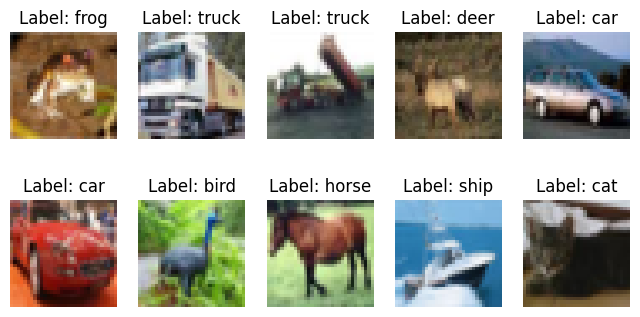

In [3]:
plot_grid(imgs[0:10], labels[0:10], classes)

In [4]:
trainset = Cifar10Dataset(root='./data', train=True, download=True, transform=augmentation('Train', mu, sigma))
testset = Cifar10Dataset(root='./data', train=False, download=True, transform=augmentation('Test', mu, sigma))

Files already downloaded and verified
Files already downloaded and verified


In [5]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)

test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)

CUDA Available? True


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 16, 16]           2,304
      BatchNorm2d-11           [-1, 16, 16, 16]              32
             ReLU-12           [-1, 16, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           4,608
      BatchNorm2d-14           [-1, 32,

In [7]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [8]:
num_epochs = 200
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.1, epochs=num_epochs, steps_per_epoch=1, verbose=True)

criterion = F.nll_loss

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train_losses, train_acc = train(model, device, train_loader, optimizer, criterion, train_losses, train_acc)
    test_losses, test_acc = test(model, device, test_loader, criterion, test_losses, test_acc)
    scheduler.step()

Adjusting learning rate of group 0 to 4.0000e-03.
Epoch 1


Train: Loss=1.9147 Batch_id=97 Accuracy=22.06: 100%|██████████| 98/98 [00:09<00:00, 10.01it/s]


Test set: Average loss: 1.7744, Accuracy: 3556/10000 (35.56%)

Adjusting learning rate of group 0 to 4.0680e-03.
Epoch 2


Train: Loss=1.7289 Batch_id=97 Accuracy=34.27: 100%|██████████| 98/98 [00:08<00:00, 11.74it/s]


Test set: Average loss: 1.6104, Accuracy: 4181/10000 (41.81%)

Adjusting learning rate of group 0 to 4.2719e-03.
Epoch 3


Train: Loss=1.4991 Batch_id=97 Accuracy=40.47: 100%|██████████| 98/98 [00:09<00:00, 10.09it/s]


Test set: Average loss: 1.3934, Accuracy: 4939/10000 (49.39%)

Adjusting learning rate of group 0 to 4.6111e-03.
Epoch 4


Train: Loss=1.4885 Batch_id=97 Accuracy=44.90: 100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Test set: Average loss: 1.2797, Accuracy: 5408/10000 (54.08%)

Adjusting learning rate of group 0 to 5.0846e-03.
Epoch 5


Train: Loss=1.4887 Batch_id=97 Accuracy=48.32: 100%|██████████| 98/98 [00:09<00:00, 10.25it/s]


Test set: Average loss: 1.1757, Accuracy: 5723/10000 (57.23%)

Adjusting learning rate of group 0 to 5.6911e-03.
Epoch 6


Train: Loss=1.3918 Batch_id=97 Accuracy=50.99: 100%|██████████| 98/98 [00:08<00:00, 11.02it/s]


Test set: Average loss: 1.2582, Accuracy: 5685/10000 (56.85%)

Adjusting learning rate of group 0 to 6.4289e-03.
Epoch 7


Train: Loss=1.2414 Batch_id=97 Accuracy=53.86: 100%|██████████| 98/98 [00:09<00:00, 10.57it/s]


Test set: Average loss: 1.1471, Accuracy: 5887/10000 (58.87%)

Adjusting learning rate of group 0 to 7.2959e-03.
Epoch 8


Train: Loss=1.1912 Batch_id=97 Accuracy=55.91: 100%|██████████| 98/98 [00:09<00:00, 10.38it/s]


Test set: Average loss: 1.0581, Accuracy: 6284/10000 (62.84%)

Adjusting learning rate of group 0 to 8.2895e-03.
Epoch 9


Train: Loss=1.2494 Batch_id=97 Accuracy=57.46: 100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Test set: Average loss: 0.9888, Accuracy: 6494/10000 (64.94%)

Adjusting learning rate of group 0 to 9.4071e-03.
Epoch 10


Train: Loss=1.1381 Batch_id=97 Accuracy=59.02: 100%|██████████| 98/98 [00:09<00:00, 10.10it/s]


Test set: Average loss: 1.0100, Accuracy: 6399/10000 (63.99%)

Adjusting learning rate of group 0 to 1.0645e-02.
Epoch 11


Train: Loss=1.0963 Batch_id=97 Accuracy=60.85: 100%|██████████| 98/98 [00:09<00:00, 10.23it/s]


Test set: Average loss: 0.9719, Accuracy: 6775/10000 (67.75%)

Adjusting learning rate of group 0 to 1.2001e-02.
Epoch 12


Train: Loss=0.9542 Batch_id=97 Accuracy=62.20: 100%|██████████| 98/98 [00:08<00:00, 11.40it/s]


Test set: Average loss: 1.0441, Accuracy: 6614/10000 (66.14%)

Adjusting learning rate of group 0 to 1.3470e-02.
Epoch 13


Train: Loss=1.0294 Batch_id=97 Accuracy=63.20: 100%|██████████| 98/98 [00:09<00:00, 10.31it/s]


Test set: Average loss: 0.8889, Accuracy: 6971/10000 (69.71%)

Adjusting learning rate of group 0 to 1.5048e-02.
Epoch 14


Train: Loss=0.9850 Batch_id=97 Accuracy=64.30: 100%|██████████| 98/98 [00:09<00:00, 10.10it/s]


Test set: Average loss: 0.9305, Accuracy: 6990/10000 (69.90%)

Adjusting learning rate of group 0 to 1.6731e-02.
Epoch 15


Train: Loss=0.9830 Batch_id=97 Accuracy=65.01: 100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


Test set: Average loss: 0.8006, Accuracy: 7249/10000 (72.49%)

Adjusting learning rate of group 0 to 1.8514e-02.
Epoch 16


Train: Loss=0.9841 Batch_id=97 Accuracy=65.67: 100%|██████████| 98/98 [00:09<00:00, 10.46it/s]


Test set: Average loss: 0.8175, Accuracy: 7286/10000 (72.86%)

Adjusting learning rate of group 0 to 2.0391e-02.
Epoch 17


Train: Loss=0.8997 Batch_id=97 Accuracy=66.40: 100%|██████████| 98/98 [00:08<00:00, 11.32it/s]


Test set: Average loss: 0.7193, Accuracy: 7488/10000 (74.88%)

Adjusting learning rate of group 0 to 2.2359e-02.
Epoch 18


Train: Loss=0.9413 Batch_id=97 Accuracy=67.51: 100%|██████████| 98/98 [00:09<00:00, 10.10it/s]


Test set: Average loss: 0.8038, Accuracy: 7228/10000 (72.28%)

Adjusting learning rate of group 0 to 2.4410e-02.
Epoch 19


Train: Loss=0.8847 Batch_id=97 Accuracy=68.11: 100%|██████████| 98/98 [00:09<00:00, 10.21it/s]


Test set: Average loss: 0.6939, Accuracy: 7630/10000 (76.30%)

Adjusting learning rate of group 0 to 2.6540e-02.
Epoch 20


Train: Loss=0.8723 Batch_id=97 Accuracy=68.60: 100%|██████████| 98/98 [00:09<00:00, 10.20it/s]


Test set: Average loss: 0.8175, Accuracy: 7434/10000 (74.34%)

Adjusting learning rate of group 0 to 2.8742e-02.
Epoch 21


Train: Loss=0.8313 Batch_id=97 Accuracy=68.77: 100%|██████████| 98/98 [00:09<00:00, 10.74it/s]


Test set: Average loss: 0.6680, Accuracy: 7735/10000 (77.35%)

Adjusting learning rate of group 0 to 3.1009e-02.
Epoch 22


Train: Loss=0.8620 Batch_id=97 Accuracy=69.27: 100%|██████████| 98/98 [00:08<00:00, 11.32it/s]


Test set: Average loss: 0.7902, Accuracy: 7381/10000 (73.81%)

Adjusting learning rate of group 0 to 3.3336e-02.
Epoch 23


Train: Loss=0.8868 Batch_id=97 Accuracy=69.67: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.6651, Accuracy: 7762/10000 (77.62%)

Adjusting learning rate of group 0 to 3.5717e-02.
Epoch 24


Train: Loss=0.8336 Batch_id=97 Accuracy=70.35: 100%|██████████| 98/98 [00:09<00:00, 10.17it/s]


Test set: Average loss: 0.6595, Accuracy: 7721/10000 (77.21%)

Adjusting learning rate of group 0 to 3.8143e-02.
Epoch 25


Train: Loss=0.8093 Batch_id=97 Accuracy=70.82: 100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Test set: Average loss: 0.7967, Accuracy: 7388/10000 (73.88%)

Adjusting learning rate of group 0 to 4.0608e-02.
Epoch 26


Train: Loss=0.7717 Batch_id=97 Accuracy=71.19: 100%|██████████| 98/98 [00:08<00:00, 11.15it/s]


Test set: Average loss: 0.6286, Accuracy: 7834/10000 (78.34%)

Adjusting learning rate of group 0 to 4.3106e-02.
Epoch 27


Train: Loss=0.7648 Batch_id=97 Accuracy=71.45: 100%|██████████| 98/98 [00:08<00:00, 11.16it/s]


Test set: Average loss: 0.6749, Accuracy: 7758/10000 (77.58%)

Adjusting learning rate of group 0 to 4.5629e-02.
Epoch 28


Train: Loss=0.7522 Batch_id=97 Accuracy=71.92: 100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Test set: Average loss: 0.7231, Accuracy: 7592/10000 (75.92%)

Adjusting learning rate of group 0 to 4.8170e-02.
Epoch 29


Train: Loss=0.7386 Batch_id=97 Accuracy=71.98: 100%|██████████| 98/98 [00:09<00:00, 10.18it/s]


Test set: Average loss: 0.6760, Accuracy: 7742/10000 (77.42%)

Adjusting learning rate of group 0 to 5.0722e-02.
Epoch 30


Train: Loss=0.7588 Batch_id=97 Accuracy=72.50: 100%|██████████| 98/98 [00:09<00:00,  9.99it/s]


Test set: Average loss: 0.6999, Accuracy: 7728/10000 (77.28%)

Adjusting learning rate of group 0 to 5.3278e-02.
Epoch 31


Train: Loss=0.7067 Batch_id=97 Accuracy=72.73: 100%|██████████| 98/98 [00:08<00:00, 11.34it/s]


Test set: Average loss: 0.6063, Accuracy: 7964/10000 (79.64%)

Adjusting learning rate of group 0 to 5.5830e-02.
Epoch 32


Train: Loss=0.6948 Batch_id=97 Accuracy=72.99: 100%|██████████| 98/98 [00:08<00:00, 10.93it/s]


Test set: Average loss: 0.5976, Accuracy: 7973/10000 (79.73%)

Adjusting learning rate of group 0 to 5.8371e-02.
Epoch 33


Train: Loss=0.7342 Batch_id=97 Accuracy=73.81: 100%|██████████| 98/98 [00:09<00:00, 10.14it/s]


Test set: Average loss: 0.6222, Accuracy: 7897/10000 (78.97%)

Adjusting learning rate of group 0 to 6.0894e-02.
Epoch 34


Train: Loss=0.7459 Batch_id=97 Accuracy=73.46: 100%|██████████| 98/98 [00:09<00:00, 10.11it/s]


Test set: Average loss: 0.6740, Accuracy: 7694/10000 (76.94%)

Adjusting learning rate of group 0 to 6.3392e-02.
Epoch 35


Train: Loss=0.7671 Batch_id=97 Accuracy=73.97: 100%|██████████| 98/98 [00:09<00:00, 10.15it/s]


Test set: Average loss: 0.5813, Accuracy: 8026/10000 (80.26%)

Adjusting learning rate of group 0 to 6.5857e-02.
Epoch 36


Train: Loss=0.8357 Batch_id=97 Accuracy=74.05: 100%|██████████| 98/98 [00:08<00:00, 11.38it/s]


Test set: Average loss: 0.5695, Accuracy: 8110/10000 (81.10%)

Adjusting learning rate of group 0 to 6.8283e-02.
Epoch 37


Train: Loss=0.8527 Batch_id=97 Accuracy=74.35: 100%|██████████| 98/98 [00:09<00:00, 10.54it/s]


Test set: Average loss: 0.6665, Accuracy: 7881/10000 (78.81%)

Adjusting learning rate of group 0 to 7.0664e-02.
Epoch 38


Train: Loss=0.7375 Batch_id=97 Accuracy=74.13: 100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Test set: Average loss: 0.5426, Accuracy: 8120/10000 (81.20%)

Adjusting learning rate of group 0 to 7.2991e-02.
Epoch 39


Train: Loss=0.7225 Batch_id=97 Accuracy=74.89: 100%|██████████| 98/98 [00:09<00:00, 10.10it/s]


Test set: Average loss: 0.5240, Accuracy: 8196/10000 (81.96%)

Adjusting learning rate of group 0 to 7.5258e-02.
Epoch 40


Train: Loss=0.7385 Batch_id=97 Accuracy=75.04: 100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


Test set: Average loss: 0.5418, Accuracy: 8178/10000 (81.78%)

Adjusting learning rate of group 0 to 7.7460e-02.
Epoch 41


Train: Loss=0.7932 Batch_id=97 Accuracy=75.28: 100%|██████████| 98/98 [00:08<00:00, 11.22it/s]


Test set: Average loss: 0.4987, Accuracy: 8264/10000 (82.64%)

Adjusting learning rate of group 0 to 7.9590e-02.
Epoch 42


Train: Loss=0.6502 Batch_id=97 Accuracy=75.40: 100%|██████████| 98/98 [00:09<00:00, 10.68it/s]


Test set: Average loss: 0.5404, Accuracy: 8162/10000 (81.62%)

Adjusting learning rate of group 0 to 8.1641e-02.
Epoch 43


Train: Loss=0.7674 Batch_id=97 Accuracy=75.52: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.5106, Accuracy: 8302/10000 (83.02%)

Adjusting learning rate of group 0 to 8.3609e-02.
Epoch 44


Train: Loss=0.6206 Batch_id=97 Accuracy=75.37: 100%|██████████| 98/98 [00:09<00:00,  9.99it/s]


Test set: Average loss: 0.5285, Accuracy: 8197/10000 (81.97%)

Adjusting learning rate of group 0 to 8.5486e-02.
Epoch 45


Train: Loss=0.6469 Batch_id=97 Accuracy=75.97: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.5110, Accuracy: 8237/10000 (82.37%)

Adjusting learning rate of group 0 to 8.7269e-02.
Epoch 46


Train: Loss=0.6812 Batch_id=97 Accuracy=76.34: 100%|██████████| 98/98 [00:09<00:00, 10.64it/s]


Test set: Average loss: 0.4965, Accuracy: 8349/10000 (83.49%)

Adjusting learning rate of group 0 to 8.8952e-02.
Epoch 47


Train: Loss=0.7576 Batch_id=97 Accuracy=76.07: 100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Test set: Average loss: 0.4728, Accuracy: 8365/10000 (83.65%)

Adjusting learning rate of group 0 to 9.0530e-02.
Epoch 48


Train: Loss=0.7152 Batch_id=97 Accuracy=76.27: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Test set: Average loss: 0.5953, Accuracy: 8029/10000 (80.29%)

Adjusting learning rate of group 0 to 9.1999e-02.
Epoch 49


Train: Loss=0.5928 Batch_id=97 Accuracy=76.42: 100%|██████████| 98/98 [00:09<00:00, 10.00it/s]


Test set: Average loss: 0.5425, Accuracy: 8142/10000 (81.42%)

Adjusting learning rate of group 0 to 9.3355e-02.
Epoch 50


Train: Loss=0.6725 Batch_id=97 Accuracy=76.98: 100%|██████████| 98/98 [00:09<00:00, 10.19it/s]


Test set: Average loss: 0.5194, Accuracy: 8258/10000 (82.58%)

Adjusting learning rate of group 0 to 9.4593e-02.
Epoch 51


Train: Loss=0.6252 Batch_id=97 Accuracy=76.77: 100%|██████████| 98/98 [00:09<00:00, 10.50it/s]


Test set: Average loss: 0.5826, Accuracy: 8075/10000 (80.75%)

Adjusting learning rate of group 0 to 9.5710e-02.
Epoch 52


Train: Loss=0.6460 Batch_id=97 Accuracy=76.86: 100%|██████████| 98/98 [00:08<00:00, 11.31it/s]


Test set: Average loss: 0.5344, Accuracy: 8231/10000 (82.31%)

Adjusting learning rate of group 0 to 9.6704e-02.
Epoch 53


Train: Loss=0.6256 Batch_id=97 Accuracy=77.37: 100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Test set: Average loss: 0.5171, Accuracy: 8257/10000 (82.57%)

Adjusting learning rate of group 0 to 9.7571e-02.
Epoch 54


Train: Loss=0.7347 Batch_id=97 Accuracy=76.88: 100%|██████████| 98/98 [00:09<00:00,  9.94it/s]


Test set: Average loss: 0.4932, Accuracy: 8323/10000 (83.23%)

Adjusting learning rate of group 0 to 9.8309e-02.
Epoch 55


Train: Loss=0.6552 Batch_id=97 Accuracy=77.14: 100%|██████████| 98/98 [00:09<00:00,  9.90it/s]


Test set: Average loss: 0.4820, Accuracy: 8372/10000 (83.72%)

Adjusting learning rate of group 0 to 9.8915e-02.
Epoch 56


Train: Loss=0.5196 Batch_id=97 Accuracy=77.61: 100%|██████████| 98/98 [00:09<00:00, 10.31it/s]


Test set: Average loss: 0.5354, Accuracy: 8259/10000 (82.59%)

Adjusting learning rate of group 0 to 9.9389e-02.
Epoch 57


Train: Loss=0.6244 Batch_id=97 Accuracy=77.70: 100%|██████████| 98/98 [00:08<00:00, 11.28it/s]


Test set: Average loss: 0.5099, Accuracy: 8307/10000 (83.07%)

Adjusting learning rate of group 0 to 9.9728e-02.
Epoch 58


Train: Loss=0.6610 Batch_id=97 Accuracy=77.44: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.5539, Accuracy: 8161/10000 (81.61%)

Adjusting learning rate of group 0 to 9.9932e-02.
Epoch 59


Train: Loss=0.6672 Batch_id=97 Accuracy=77.80: 100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


Test set: Average loss: 0.4953, Accuracy: 8351/10000 (83.51%)

Adjusting learning rate of group 0 to 1.0000e-01.
Epoch 60


Train: Loss=0.7130 Batch_id=97 Accuracy=77.92: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.5122, Accuracy: 8268/10000 (82.68%)

Adjusting learning rate of group 0 to 9.9987e-02.
Epoch 61


Train: Loss=0.6024 Batch_id=97 Accuracy=78.29: 100%|██████████| 98/98 [00:09<00:00, 10.57it/s]


Test set: Average loss: 0.4995, Accuracy: 8315/10000 (83.15%)

Adjusting learning rate of group 0 to 9.9950e-02.
Epoch 62


Train: Loss=0.6980 Batch_id=97 Accuracy=78.30: 100%|██████████| 98/98 [00:08<00:00, 11.17it/s]


Test set: Average loss: 0.5242, Accuracy: 8261/10000 (82.61%)

Adjusting learning rate of group 0 to 9.9887e-02.
Epoch 63


Train: Loss=0.6466 Batch_id=97 Accuracy=78.65: 100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


Test set: Average loss: 0.5311, Accuracy: 8221/10000 (82.21%)

Adjusting learning rate of group 0 to 9.9799e-02.
Epoch 64


Train: Loss=0.5389 Batch_id=97 Accuracy=78.56: 100%|██████████| 98/98 [00:09<00:00,  9.99it/s]


Test set: Average loss: 0.4440, Accuracy: 8492/10000 (84.92%)

Adjusting learning rate of group 0 to 9.9686e-02.
Epoch 65


Train: Loss=0.6190 Batch_id=97 Accuracy=78.30: 100%|██████████| 98/98 [00:09<00:00, 10.01it/s]


Test set: Average loss: 0.4714, Accuracy: 8404/10000 (84.04%)

Adjusting learning rate of group 0 to 9.9547e-02.
Epoch 66


Train: Loss=0.7379 Batch_id=97 Accuracy=78.45: 100%|██████████| 98/98 [00:09<00:00, 10.19it/s]


Test set: Average loss: 0.4828, Accuracy: 8383/10000 (83.83%)

Adjusting learning rate of group 0 to 9.9384e-02.
Epoch 67


Train: Loss=0.6409 Batch_id=97 Accuracy=78.84: 100%|██████████| 98/98 [00:08<00:00, 11.17it/s]


Test set: Average loss: 0.4340, Accuracy: 8521/10000 (85.21%)

Adjusting learning rate of group 0 to 9.9196e-02.
Epoch 68


Train: Loss=0.5435 Batch_id=97 Accuracy=79.26: 100%|██████████| 98/98 [00:09<00:00,  9.98it/s]


Test set: Average loss: 0.4602, Accuracy: 8466/10000 (84.66%)

Adjusting learning rate of group 0 to 9.8984e-02.
Epoch 69


Train: Loss=0.6136 Batch_id=97 Accuracy=78.55: 100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


Test set: Average loss: 0.4694, Accuracy: 8453/10000 (84.53%)

Adjusting learning rate of group 0 to 9.8746e-02.
Epoch 70


Train: Loss=0.5561 Batch_id=97 Accuracy=78.93: 100%|██████████| 98/98 [00:09<00:00,  9.91it/s]


Test set: Average loss: 0.4399, Accuracy: 8515/10000 (85.15%)

Adjusting learning rate of group 0 to 9.8484e-02.
Epoch 71


Train: Loss=0.6817 Batch_id=97 Accuracy=79.04: 100%|██████████| 98/98 [00:09<00:00, 10.28it/s]


Test set: Average loss: 0.4741, Accuracy: 8406/10000 (84.06%)

Adjusting learning rate of group 0 to 9.8198e-02.
Epoch 72


Train: Loss=0.5697 Batch_id=97 Accuracy=79.11: 100%|██████████| 98/98 [00:08<00:00, 11.35it/s]


Test set: Average loss: 0.4386, Accuracy: 8498/10000 (84.98%)

Adjusting learning rate of group 0 to 9.7888e-02.
Epoch 73


Train: Loss=0.6067 Batch_id=97 Accuracy=79.11: 100%|██████████| 98/98 [00:09<00:00, 10.20it/s]


Test set: Average loss: 0.4903, Accuracy: 8369/10000 (83.69%)

Adjusting learning rate of group 0 to 9.7553e-02.
Epoch 74


Train: Loss=0.6023 Batch_id=97 Accuracy=79.50: 100%|██████████| 98/98 [00:09<00:00, 10.22it/s]


Test set: Average loss: 0.4600, Accuracy: 8421/10000 (84.21%)

Adjusting learning rate of group 0 to 9.7194e-02.
Epoch 75


Train: Loss=0.6541 Batch_id=97 Accuracy=79.20: 100%|██████████| 98/98 [00:09<00:00, 10.10it/s]


Test set: Average loss: 0.4637, Accuracy: 8458/10000 (84.58%)

Adjusting learning rate of group 0 to 9.6812e-02.
Epoch 76


Train: Loss=0.6737 Batch_id=97 Accuracy=79.83: 100%|██████████| 98/98 [00:09<00:00, 10.68it/s]


Test set: Average loss: 0.4376, Accuracy: 8545/10000 (85.45%)

Adjusting learning rate of group 0 to 9.6406e-02.
Epoch 77


Train: Loss=0.5993 Batch_id=97 Accuracy=79.58: 100%|██████████| 98/98 [00:08<00:00, 11.31it/s]


Test set: Average loss: 0.4417, Accuracy: 8553/10000 (85.53%)

Adjusting learning rate of group 0 to 9.5976e-02.
Epoch 78


Train: Loss=0.5983 Batch_id=97 Accuracy=79.48: 100%|██████████| 98/98 [00:09<00:00, 10.01it/s]


Test set: Average loss: 0.4424, Accuracy: 8525/10000 (85.25%)

Adjusting learning rate of group 0 to 9.5524e-02.
Epoch 79


Train: Loss=0.5189 Batch_id=97 Accuracy=79.90: 100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


Test set: Average loss: 0.4956, Accuracy: 8320/10000 (83.20%)

Adjusting learning rate of group 0 to 9.5048e-02.
Epoch 80


Train: Loss=0.5246 Batch_id=97 Accuracy=79.69: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Test set: Average loss: 0.4661, Accuracy: 8456/10000 (84.56%)

Adjusting learning rate of group 0 to 9.4550e-02.
Epoch 81


Train: Loss=0.6046 Batch_id=97 Accuracy=79.79: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Test set: Average loss: 0.4420, Accuracy: 8508/10000 (85.08%)

Adjusting learning rate of group 0 to 9.4030e-02.
Epoch 82


Train: Loss=0.5373 Batch_id=97 Accuracy=79.91: 100%|██████████| 98/98 [00:09<00:00, 10.72it/s]


Test set: Average loss: 0.4327, Accuracy: 8538/10000 (85.38%)

Adjusting learning rate of group 0 to 9.3487e-02.
Epoch 83


Train: Loss=0.6286 Batch_id=97 Accuracy=80.27: 100%|██████████| 98/98 [00:09<00:00, 10.25it/s]


Test set: Average loss: 0.4549, Accuracy: 8501/10000 (85.01%)

Adjusting learning rate of group 0 to 9.2922e-02.
Epoch 84


Train: Loss=0.6384 Batch_id=97 Accuracy=80.12: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s]


Test set: Average loss: 0.4421, Accuracy: 8508/10000 (85.08%)

Adjusting learning rate of group 0 to 9.2336e-02.
Epoch 85


Train: Loss=0.5184 Batch_id=97 Accuracy=80.07: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s]


Test set: Average loss: 0.4698, Accuracy: 8396/10000 (83.96%)

Adjusting learning rate of group 0 to 9.1729e-02.
Epoch 86


Train: Loss=0.6104 Batch_id=97 Accuracy=80.23: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s]


Test set: Average loss: 0.4605, Accuracy: 8473/10000 (84.73%)

Adjusting learning rate of group 0 to 9.1100e-02.
Epoch 87


Train: Loss=0.5146 Batch_id=97 Accuracy=80.33: 100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


Test set: Average loss: 0.4542, Accuracy: 8493/10000 (84.93%)

Adjusting learning rate of group 0 to 9.0451e-02.
Epoch 88


Train: Loss=0.5515 Batch_id=97 Accuracy=80.16: 100%|██████████| 98/98 [00:09<00:00, 10.64it/s]


Test set: Average loss: 0.4634, Accuracy: 8453/10000 (84.53%)

Adjusting learning rate of group 0 to 8.9781e-02.
Epoch 89


Train: Loss=0.5564 Batch_id=97 Accuracy=80.17: 100%|██████████| 98/98 [00:09<00:00, 10.35it/s]


Test set: Average loss: 0.4407, Accuracy: 8516/10000 (85.16%)

Adjusting learning rate of group 0 to 8.9092e-02.
Epoch 90


Train: Loss=0.5747 Batch_id=97 Accuracy=80.55: 100%|██████████| 98/98 [00:10<00:00,  9.64it/s]


Test set: Average loss: 0.4475, Accuracy: 8562/10000 (85.62%)

Adjusting learning rate of group 0 to 8.8382e-02.
Epoch 91


Train: Loss=0.6191 Batch_id=97 Accuracy=80.74: 100%|██████████| 98/98 [00:10<00:00,  9.66it/s]


Test set: Average loss: 0.4627, Accuracy: 8468/10000 (84.68%)

Adjusting learning rate of group 0 to 8.7654e-02.
Epoch 92


Train: Loss=0.5826 Batch_id=97 Accuracy=80.40: 100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


Test set: Average loss: 0.4390, Accuracy: 8515/10000 (85.15%)

Adjusting learning rate of group 0 to 8.6906e-02.
Epoch 93


Train: Loss=0.5539 Batch_id=97 Accuracy=80.39: 100%|██████████| 98/98 [00:09<00:00,  9.81it/s]


Test set: Average loss: 0.4662, Accuracy: 8494/10000 (84.94%)

Adjusting learning rate of group 0 to 8.6140e-02.
Epoch 94


Train: Loss=0.5493 Batch_id=97 Accuracy=80.88: 100%|██████████| 98/98 [00:08<00:00, 10.94it/s]


Test set: Average loss: 0.4315, Accuracy: 8562/10000 (85.62%)

Adjusting learning rate of group 0 to 8.5355e-02.
Epoch 95


Train: Loss=0.5844 Batch_id=97 Accuracy=80.47: 100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Test set: Average loss: 0.4412, Accuracy: 8505/10000 (85.05%)

Adjusting learning rate of group 0 to 8.4553e-02.
Epoch 96


Train: Loss=0.5758 Batch_id=97 Accuracy=80.50: 100%|██████████| 98/98 [00:10<00:00,  9.49it/s]


Test set: Average loss: 0.4500, Accuracy: 8532/10000 (85.32%)

Adjusting learning rate of group 0 to 8.3734e-02.
Epoch 97


Train: Loss=0.5633 Batch_id=97 Accuracy=80.97: 100%|██████████| 98/98 [00:10<00:00,  9.58it/s]


Test set: Average loss: 0.4419, Accuracy: 8507/10000 (85.07%)

Adjusting learning rate of group 0 to 8.2897e-02.
Epoch 98


Train: Loss=0.5059 Batch_id=97 Accuracy=80.91: 100%|██████████| 98/98 [00:10<00:00,  9.64it/s]


Test set: Average loss: 0.4546, Accuracy: 8482/10000 (84.82%)

Adjusting learning rate of group 0 to 8.2044e-02.
Epoch 99


Train: Loss=0.5429 Batch_id=97 Accuracy=81.15: 100%|██████████| 98/98 [00:09<00:00, 10.15it/s]


Test set: Average loss: 0.4242, Accuracy: 8571/10000 (85.71%)

Adjusting learning rate of group 0 to 8.1175e-02.
Epoch 100


Train: Loss=0.4908 Batch_id=97 Accuracy=81.19: 100%|██████████| 98/98 [00:09<00:00, 10.70it/s]


Test set: Average loss: 0.4167, Accuracy: 8644/10000 (86.44%)

Adjusting learning rate of group 0 to 8.0290e-02.
Epoch 101


Train: Loss=0.5400 Batch_id=97 Accuracy=81.19: 100%|██████████| 98/98 [00:09<00:00,  9.91it/s]


Test set: Average loss: 0.4268, Accuracy: 8574/10000 (85.74%)

Adjusting learning rate of group 0 to 7.9389e-02.
Epoch 102


Train: Loss=0.6163 Batch_id=97 Accuracy=81.29: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s]


Test set: Average loss: 0.4300, Accuracy: 8538/10000 (85.38%)

Adjusting learning rate of group 0 to 7.8474e-02.
Epoch 103


Train: Loss=0.5832 Batch_id=97 Accuracy=81.22: 100%|██████████| 98/98 [00:10<00:00,  9.63it/s]


Test set: Average loss: 0.4275, Accuracy: 8559/10000 (85.59%)

Adjusting learning rate of group 0 to 7.7545e-02.
Epoch 104


Train: Loss=0.4537 Batch_id=97 Accuracy=81.38: 100%|██████████| 98/98 [00:10<00:00,  9.70it/s]


Test set: Average loss: 0.4330, Accuracy: 8543/10000 (85.43%)

Adjusting learning rate of group 0 to 7.6602e-02.
Epoch 105


Train: Loss=0.5952 Batch_id=97 Accuracy=81.47: 100%|██████████| 98/98 [00:09<00:00, 10.10it/s]


Test set: Average loss: 0.4238, Accuracy: 8582/10000 (85.82%)

Adjusting learning rate of group 0 to 7.5645e-02.
Epoch 106


Train: Loss=0.4916 Batch_id=97 Accuracy=81.32: 100%|██████████| 98/98 [00:08<00:00, 10.93it/s]


Test set: Average loss: 0.4173, Accuracy: 8604/10000 (86.04%)

Adjusting learning rate of group 0 to 7.4676e-02.
Epoch 107


Train: Loss=0.5601 Batch_id=97 Accuracy=81.38: 100%|██████████| 98/98 [00:10<00:00,  9.53it/s]


Test set: Average loss: 0.4177, Accuracy: 8595/10000 (85.95%)

Adjusting learning rate of group 0 to 7.3694e-02.
Epoch 108


Train: Loss=0.5384 Batch_id=97 Accuracy=81.43: 100%|██████████| 98/98 [00:10<00:00,  9.67it/s]


Test set: Average loss: 0.4270, Accuracy: 8572/10000 (85.72%)

Adjusting learning rate of group 0 to 7.2700e-02.
Epoch 109


Train: Loss=0.5800 Batch_id=97 Accuracy=81.34: 100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


Test set: Average loss: 0.4422, Accuracy: 8543/10000 (85.43%)

Adjusting learning rate of group 0 to 7.1694e-02.
Epoch 110


Train: Loss=0.5428 Batch_id=97 Accuracy=81.48: 100%|██████████| 98/98 [00:10<00:00,  9.51it/s]


Test set: Average loss: 0.4415, Accuracy: 8533/10000 (85.33%)

Adjusting learning rate of group 0 to 7.0678e-02.
Epoch 111


Train: Loss=0.6091 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Test set: Average loss: 0.4105, Accuracy: 8614/10000 (86.14%)

Adjusting learning rate of group 0 to 6.9651e-02.
Epoch 112


Train: Loss=0.5696 Batch_id=97 Accuracy=81.80: 100%|██████████| 98/98 [00:09<00:00, 10.68it/s]


Test set: Average loss: 0.4053, Accuracy: 8619/10000 (86.19%)

Adjusting learning rate of group 0 to 6.8615e-02.
Epoch 113


Train: Loss=0.5297 Batch_id=97 Accuracy=81.65: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.3997, Accuracy: 8664/10000 (86.64%)

Adjusting learning rate of group 0 to 6.7569e-02.
Epoch 114


Train: Loss=0.4729 Batch_id=97 Accuracy=81.93: 100%|██████████| 98/98 [00:10<00:00,  9.51it/s]


Test set: Average loss: 0.4132, Accuracy: 8632/10000 (86.32%)

Adjusting learning rate of group 0 to 6.6514e-02.
Epoch 115


Train: Loss=0.5346 Batch_id=97 Accuracy=81.91: 100%|██████████| 98/98 [00:10<00:00,  9.67it/s]


Test set: Average loss: 0.4166, Accuracy: 8586/10000 (85.86%)

Adjusting learning rate of group 0 to 6.5451e-02.
Epoch 116


Train: Loss=0.4656 Batch_id=97 Accuracy=81.97: 100%|██████████| 98/98 [00:10<00:00,  9.62it/s]


Test set: Average loss: 0.4471, Accuracy: 8558/10000 (85.58%)

Adjusting learning rate of group 0 to 6.4380e-02.
Epoch 117


Train: Loss=0.5739 Batch_id=97 Accuracy=81.61: 100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Test set: Average loss: 0.4022, Accuracy: 8644/10000 (86.44%)

Adjusting learning rate of group 0 to 6.3302e-02.
Epoch 118


Train: Loss=0.5222 Batch_id=97 Accuracy=82.16: 100%|██████████| 98/98 [00:09<00:00, 10.85it/s]


Test set: Average loss: 0.4014, Accuracy: 8644/10000 (86.44%)

Adjusting learning rate of group 0 to 6.2217e-02.
Epoch 119


Train: Loss=0.5326 Batch_id=97 Accuracy=82.22: 100%|██████████| 98/98 [00:09<00:00, 10.09it/s]


Test set: Average loss: 0.4187, Accuracy: 8564/10000 (85.64%)

Adjusting learning rate of group 0 to 6.1126e-02.
Epoch 120


Train: Loss=0.5362 Batch_id=97 Accuracy=81.95: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Test set: Average loss: 0.4429, Accuracy: 8531/10000 (85.31%)

Adjusting learning rate of group 0 to 6.0030e-02.
Epoch 121


Train: Loss=0.4946 Batch_id=97 Accuracy=82.29: 100%|██████████| 98/98 [00:10<00:00,  9.68it/s]


Test set: Average loss: 0.4218, Accuracy: 8577/10000 (85.77%)

Adjusting learning rate of group 0 to 5.8928e-02.
Epoch 122


Train: Loss=0.5180 Batch_id=97 Accuracy=82.29: 100%|██████████| 98/98 [00:09<00:00,  9.87it/s]


Test set: Average loss: 0.3893, Accuracy: 8708/10000 (87.08%)

Adjusting learning rate of group 0 to 5.7822e-02.
Epoch 123


Train: Loss=0.5249 Batch_id=97 Accuracy=82.32: 100%|██████████| 98/98 [00:09<00:00, 10.55it/s]


Test set: Average loss: 0.4149, Accuracy: 8595/10000 (85.95%)

Adjusting learning rate of group 0 to 5.6712e-02.
Epoch 124


Train: Loss=0.5338 Batch_id=97 Accuracy=82.36: 100%|██████████| 98/98 [00:09<00:00, 10.68it/s]


Test set: Average loss: 0.3864, Accuracy: 8696/10000 (86.96%)

Adjusting learning rate of group 0 to 5.5598e-02.
Epoch 125


Train: Loss=0.5250 Batch_id=97 Accuracy=82.24: 100%|██████████| 98/98 [00:10<00:00,  9.65it/s]


Test set: Average loss: 0.4458, Accuracy: 8522/10000 (85.22%)

Adjusting learning rate of group 0 to 5.4482e-02.
Epoch 126


Train: Loss=0.5102 Batch_id=97 Accuracy=82.14: 100%|██████████| 98/98 [00:09<00:00,  9.94it/s]


Test set: Average loss: 0.4200, Accuracy: 8587/10000 (85.87%)

Adjusting learning rate of group 0 to 5.3364e-02.
Epoch 127


Train: Loss=0.4748 Batch_id=97 Accuracy=82.60: 100%|██████████| 98/98 [00:10<00:00,  9.69it/s]


Test set: Average loss: 0.3983, Accuracy: 8608/10000 (86.08%)

Adjusting learning rate of group 0 to 5.2243e-02.
Epoch 128


Train: Loss=0.5028 Batch_id=97 Accuracy=82.57: 100%|██████████| 98/98 [00:10<00:00,  9.78it/s]


Test set: Average loss: 0.4079, Accuracy: 8630/10000 (86.30%)

Adjusting learning rate of group 0 to 5.1122e-02.
Epoch 129


Train: Loss=0.4242 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:08<00:00, 11.12it/s]


Test set: Average loss: 0.4079, Accuracy: 8648/10000 (86.48%)

Adjusting learning rate of group 0 to 5.0000e-02.
Epoch 130


Train: Loss=0.5399 Batch_id=97 Accuracy=82.44: 100%|██████████| 98/98 [00:09<00:00,  9.91it/s]


Test set: Average loss: 0.4024, Accuracy: 8639/10000 (86.39%)

Adjusting learning rate of group 0 to 4.8878e-02.
Epoch 131


Train: Loss=0.5252 Batch_id=97 Accuracy=82.57: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Test set: Average loss: 0.3819, Accuracy: 8715/10000 (87.15%)

Adjusting learning rate of group 0 to 4.7757e-02.
Epoch 132


Train: Loss=0.6482 Batch_id=97 Accuracy=82.68: 100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


Test set: Average loss: 0.3830, Accuracy: 8744/10000 (87.44%)

Adjusting learning rate of group 0 to 4.6637e-02.
Epoch 133


Train: Loss=0.4556 Batch_id=97 Accuracy=82.88: 100%|██████████| 98/98 [00:09<00:00, 10.00it/s]


Test set: Average loss: 0.4269, Accuracy: 8584/10000 (85.84%)

Adjusting learning rate of group 0 to 4.5518e-02.
Epoch 134


Train: Loss=0.4661 Batch_id=97 Accuracy=82.87: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.4120, Accuracy: 8621/10000 (86.21%)

Adjusting learning rate of group 0 to 4.4402e-02.
Epoch 135


Train: Loss=0.5006 Batch_id=97 Accuracy=82.73: 100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Test set: Average loss: 0.3797, Accuracy: 8725/10000 (87.25%)

Adjusting learning rate of group 0 to 4.3289e-02.
Epoch 136


Train: Loss=0.4710 Batch_id=97 Accuracy=83.24: 100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


Test set: Average loss: 0.4235, Accuracy: 8609/10000 (86.09%)

Adjusting learning rate of group 0 to 4.2179e-02.
Epoch 137


Train: Loss=0.4684 Batch_id=97 Accuracy=83.24: 100%|██████████| 98/98 [00:09<00:00,  9.89it/s]


Test set: Average loss: 0.3857, Accuracy: 8741/10000 (87.41%)

Adjusting learning rate of group 0 to 4.1072e-02.
Epoch 138


Train: Loss=0.4928 Batch_id=97 Accuracy=82.90: 100%|██████████| 98/98 [00:13<00:00,  7.51it/s]


Test set: Average loss: 0.3809, Accuracy: 8712/10000 (87.12%)

Adjusting learning rate of group 0 to 3.9971e-02.
Epoch 139


Train: Loss=0.5036 Batch_id=97 Accuracy=82.91: 100%|██████████| 98/98 [00:10<00:00,  9.59it/s]


Test set: Average loss: 0.3866, Accuracy: 8691/10000 (86.91%)

Adjusting learning rate of group 0 to 3.8874e-02.
Epoch 140


Train: Loss=0.4414 Batch_id=97 Accuracy=83.00: 100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Test set: Average loss: 0.3830, Accuracy: 8735/10000 (87.35%)

Adjusting learning rate of group 0 to 3.7783e-02.
Epoch 141


Train: Loss=0.4604 Batch_id=97 Accuracy=83.37: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Test set: Average loss: 0.4086, Accuracy: 8643/10000 (86.43%)

Adjusting learning rate of group 0 to 3.6698e-02.
Epoch 142


Train: Loss=0.4239 Batch_id=97 Accuracy=83.30: 100%|██████████| 98/98 [00:09<00:00, 10.23it/s]


Test set: Average loss: 0.3734, Accuracy: 8746/10000 (87.46%)

Adjusting learning rate of group 0 to 3.5620e-02.
Epoch 143


Train: Loss=0.5107 Batch_id=97 Accuracy=83.00: 100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Test set: Average loss: 0.3985, Accuracy: 8689/10000 (86.89%)

Adjusting learning rate of group 0 to 3.4549e-02.
Epoch 144


Train: Loss=0.4782 Batch_id=97 Accuracy=83.40: 100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


Test set: Average loss: 0.3861, Accuracy: 8718/10000 (87.18%)

Adjusting learning rate of group 0 to 3.3486e-02.
Epoch 145


Train: Loss=0.5068 Batch_id=97 Accuracy=83.32: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.4035, Accuracy: 8645/10000 (86.45%)

Adjusting learning rate of group 0 to 3.2432e-02.
Epoch 146


Train: Loss=0.3795 Batch_id=97 Accuracy=83.36: 100%|██████████| 98/98 [00:08<00:00, 10.95it/s]


Test set: Average loss: 0.3982, Accuracy: 8695/10000 (86.95%)

Adjusting learning rate of group 0 to 3.1386e-02.
Epoch 147


Train: Loss=0.5044 Batch_id=97 Accuracy=83.46: 100%|██████████| 98/98 [00:09<00:00, 10.42it/s]


Test set: Average loss: 0.3951, Accuracy: 8672/10000 (86.72%)

Adjusting learning rate of group 0 to 3.0349e-02.
Epoch 148


Train: Loss=0.4249 Batch_id=97 Accuracy=83.61: 100%|██████████| 98/98 [00:09<00:00,  9.93it/s]


Test set: Average loss: 0.3906, Accuracy: 8707/10000 (87.07%)

Adjusting learning rate of group 0 to 2.9322e-02.
Epoch 149


Train: Loss=0.4576 Batch_id=97 Accuracy=83.78: 100%|██████████| 98/98 [00:09<00:00,  9.85it/s]


Test set: Average loss: 0.3840, Accuracy: 8755/10000 (87.55%)

Adjusting learning rate of group 0 to 2.8306e-02.
Epoch 150


Train: Loss=0.6044 Batch_id=97 Accuracy=83.24: 100%|██████████| 98/98 [00:10<00:00,  9.74it/s]


Test set: Average loss: 0.3794, Accuracy: 8756/10000 (87.56%)

Adjusting learning rate of group 0 to 2.7301e-02.
Epoch 151


Train: Loss=0.4270 Batch_id=97 Accuracy=83.68: 100%|██████████| 98/98 [00:09<00:00, 10.49it/s]


Test set: Average loss: 0.3847, Accuracy: 8700/10000 (87.00%)

Adjusting learning rate of group 0 to 2.6307e-02.
Epoch 152


Train: Loss=0.5454 Batch_id=97 Accuracy=83.87: 100%|██████████| 98/98 [00:08<00:00, 11.03it/s]


Test set: Average loss: 0.3850, Accuracy: 8734/10000 (87.34%)

Adjusting learning rate of group 0 to 2.5325e-02.
Epoch 153


Train: Loss=0.4584 Batch_id=97 Accuracy=83.62: 100%|██████████| 98/98 [00:09<00:00, 10.04it/s]


Test set: Average loss: 0.3871, Accuracy: 8762/10000 (87.62%)

Adjusting learning rate of group 0 to 2.4355e-02.
Epoch 154


Train: Loss=0.4897 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.3862, Accuracy: 8742/10000 (87.42%)

Adjusting learning rate of group 0 to 2.3399e-02.
Epoch 155


Train: Loss=0.4963 Batch_id=97 Accuracy=83.61: 100%|██████████| 98/98 [00:09<00:00, 10.04it/s]


Test set: Average loss: 0.3716, Accuracy: 8785/10000 (87.85%)

Adjusting learning rate of group 0 to 2.2455e-02.
Epoch 156


Train: Loss=0.4407 Batch_id=97 Accuracy=84.05: 100%|██████████| 98/98 [00:09<00:00, 10.82it/s]


Test set: Average loss: 0.3807, Accuracy: 8735/10000 (87.35%)

Adjusting learning rate of group 0 to 2.1526e-02.
Epoch 157


Train: Loss=0.4721 Batch_id=97 Accuracy=83.83: 100%|██████████| 98/98 [00:08<00:00, 10.90it/s]


Test set: Average loss: 0.3744, Accuracy: 8788/10000 (87.88%)

Adjusting learning rate of group 0 to 2.0611e-02.
Epoch 158


Train: Loss=0.4739 Batch_id=97 Accuracy=84.14: 100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Test set: Average loss: 0.3830, Accuracy: 8757/10000 (87.57%)

Adjusting learning rate of group 0 to 1.9711e-02.
Epoch 159


Train: Loss=0.4824 Batch_id=97 Accuracy=84.01: 100%|██████████| 98/98 [00:09<00:00,  9.98it/s]


Test set: Average loss: 0.3748, Accuracy: 8773/10000 (87.73%)

Adjusting learning rate of group 0 to 1.8826e-02.
Epoch 160


Train: Loss=0.4714 Batch_id=97 Accuracy=84.18: 100%|██████████| 98/98 [00:09<00:00, 10.23it/s]


Test set: Average loss: 0.3739, Accuracy: 8773/10000 (87.73%)

Adjusting learning rate of group 0 to 1.7957e-02.
Epoch 161


Train: Loss=0.4124 Batch_id=97 Accuracy=84.15: 100%|██████████| 98/98 [00:08<00:00, 11.17it/s]


Test set: Average loss: 0.3842, Accuracy: 8745/10000 (87.45%)

Adjusting learning rate of group 0 to 1.7103e-02.
Epoch 162


Train: Loss=0.4320 Batch_id=97 Accuracy=84.20: 100%|██████████| 98/98 [00:09<00:00, 10.73it/s]


Test set: Average loss: 0.3747, Accuracy: 8792/10000 (87.92%)

Adjusting learning rate of group 0 to 1.6267e-02.
Epoch 163


Train: Loss=0.4253 Batch_id=97 Accuracy=84.53: 100%|██████████| 98/98 [00:09<00:00, 10.08it/s]


Test set: Average loss: 0.3691, Accuracy: 8790/10000 (87.90%)

Adjusting learning rate of group 0 to 1.5447e-02.
Epoch 164


Train: Loss=0.4379 Batch_id=97 Accuracy=84.37: 100%|██████████| 98/98 [00:09<00:00, 10.12it/s]


Test set: Average loss: 0.3843, Accuracy: 8739/10000 (87.39%)

Adjusting learning rate of group 0 to 1.4645e-02.
Epoch 165


Train: Loss=0.4295 Batch_id=97 Accuracy=84.37: 100%|██████████| 98/98 [00:09<00:00, 10.06it/s]


Test set: Average loss: 0.3619, Accuracy: 8812/10000 (88.12%)

Adjusting learning rate of group 0 to 1.3861e-02.
Epoch 166


Train: Loss=0.4697 Batch_id=97 Accuracy=84.38: 100%|██████████| 98/98 [00:09<00:00, 10.79it/s]


Test set: Average loss: 0.3749, Accuracy: 8813/10000 (88.13%)

Adjusting learning rate of group 0 to 1.3094e-02.
Epoch 167


Train: Loss=0.5106 Batch_id=97 Accuracy=84.57: 100%|██████████| 98/98 [00:08<00:00, 11.13it/s]


Test set: Average loss: 0.3649, Accuracy: 8799/10000 (87.99%)

Adjusting learning rate of group 0 to 1.2347e-02.
Epoch 168


Train: Loss=0.4067 Batch_id=97 Accuracy=84.87: 100%|██████████| 98/98 [00:09<00:00, 10.05it/s]


Test set: Average loss: 0.3653, Accuracy: 8812/10000 (88.12%)

Adjusting learning rate of group 0 to 1.1618e-02.
Epoch 169


Train: Loss=0.4183 Batch_id=97 Accuracy=84.99: 100%|██████████| 98/98 [00:09<00:00, 10.16it/s]


Test set: Average loss: 0.3618, Accuracy: 8780/10000 (87.80%)

Adjusting learning rate of group 0 to 1.0909e-02.
Epoch 170


Train: Loss=0.4852 Batch_id=97 Accuracy=84.78: 100%|██████████| 98/98 [00:09<00:00,  9.95it/s]


Test set: Average loss: 0.3608, Accuracy: 8811/10000 (88.11%)

Adjusting learning rate of group 0 to 1.0219e-02.
Epoch 171


Train: Loss=0.5231 Batch_id=97 Accuracy=84.83: 100%|██████████| 98/98 [00:09<00:00, 10.65it/s]


Test set: Average loss: 0.3694, Accuracy: 8796/10000 (87.96%)

Adjusting learning rate of group 0 to 9.5495e-03.
Epoch 172


Train: Loss=0.4645 Batch_id=97 Accuracy=84.93: 100%|██████████| 98/98 [00:08<00:00, 11.35it/s]


Test set: Average loss: 0.3708, Accuracy: 8784/10000 (87.84%)

Adjusting learning rate of group 0 to 8.9003e-03.
Epoch 173


Train: Loss=0.4611 Batch_id=97 Accuracy=84.82: 100%|██████████| 98/98 [00:09<00:00,  9.99it/s]


Test set: Average loss: 0.3696, Accuracy: 8814/10000 (88.14%)

Adjusting learning rate of group 0 to 8.2717e-03.
Epoch 174


Train: Loss=0.4974 Batch_id=97 Accuracy=84.86: 100%|██████████| 98/98 [00:09<00:00, 10.04it/s]


Test set: Average loss: 0.3613, Accuracy: 8830/10000 (88.30%)

Adjusting learning rate of group 0 to 7.6642e-03.
Epoch 175


Train: Loss=0.3449 Batch_id=97 Accuracy=85.00: 100%|██████████| 98/98 [00:09<00:00, 10.07it/s]


Test set: Average loss: 0.3602, Accuracy: 8835/10000 (88.35%)

Adjusting learning rate of group 0 to 7.0779e-03.
Epoch 176


Train: Loss=0.4271 Batch_id=97 Accuracy=85.08: 100%|██████████| 98/98 [00:08<00:00, 10.92it/s]


Test set: Average loss: 0.3644, Accuracy: 8810/10000 (88.10%)

Adjusting learning rate of group 0 to 6.5133e-03.
Epoch 177


Train: Loss=0.4774 Batch_id=97 Accuracy=85.30: 100%|██████████| 98/98 [00:08<00:00, 11.09it/s]


Test set: Average loss: 0.3574, Accuracy: 8834/10000 (88.34%)

Adjusting learning rate of group 0 to 5.9706e-03.
Epoch 178


Train: Loss=0.3810 Batch_id=97 Accuracy=85.02: 100%|██████████| 98/98 [00:09<00:00,  9.98it/s]


Test set: Average loss: 0.3580, Accuracy: 8824/10000 (88.24%)

Adjusting learning rate of group 0 to 5.4501e-03.
Epoch 179


Train: Loss=0.4675 Batch_id=97 Accuracy=85.18: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.3555, Accuracy: 8843/10000 (88.43%)

Adjusting learning rate of group 0 to 4.9519e-03.
Epoch 180


Train: Loss=0.4110 Batch_id=97 Accuracy=85.30: 100%|██████████| 98/98 [00:09<00:00, 10.00it/s]


Test set: Average loss: 0.3593, Accuracy: 8821/10000 (88.21%)

Adjusting learning rate of group 0 to 4.4765e-03.
Epoch 181


Train: Loss=0.4485 Batch_id=97 Accuracy=85.23: 100%|██████████| 98/98 [00:08<00:00, 11.24it/s]


Test set: Average loss: 0.3578, Accuracy: 8850/10000 (88.50%)

Adjusting learning rate of group 0 to 4.0240e-03.
Epoch 182


Train: Loss=0.4837 Batch_id=97 Accuracy=85.38: 100%|██████████| 98/98 [00:09<00:00, 10.66it/s]


Test set: Average loss: 0.3623, Accuracy: 8823/10000 (88.23%)

Adjusting learning rate of group 0 to 3.5946e-03.
Epoch 183


Train: Loss=0.3998 Batch_id=97 Accuracy=85.52: 100%|██████████| 98/98 [00:09<00:00, 10.03it/s]


Test set: Average loss: 0.3561, Accuracy: 8843/10000 (88.43%)

Adjusting learning rate of group 0 to 3.1886e-03.
Epoch 184


Train: Loss=0.4288 Batch_id=97 Accuracy=85.44: 100%|██████████| 98/98 [00:09<00:00, 10.13it/s]


Test set: Average loss: 0.3566, Accuracy: 8840/10000 (88.40%)

Adjusting learning rate of group 0 to 2.8062e-03.
Epoch 185


Train: Loss=0.4602 Batch_id=97 Accuracy=85.28: 100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Test set: Average loss: 0.3569, Accuracy: 8834/10000 (88.34%)

Adjusting learning rate of group 0 to 2.4476e-03.
Epoch 186


Train: Loss=0.4693 Batch_id=97 Accuracy=85.67: 100%|██████████| 98/98 [00:08<00:00, 10.99it/s]


Test set: Average loss: 0.3545, Accuracy: 8843/10000 (88.43%)

Adjusting learning rate of group 0 to 2.1129e-03.
Epoch 187


Train: Loss=0.5009 Batch_id=97 Accuracy=85.58: 100%|██████████| 98/98 [00:08<00:00, 11.07it/s]


Test set: Average loss: 0.3576, Accuracy: 8847/10000 (88.47%)

Adjusting learning rate of group 0 to 1.8022e-03.
Epoch 188


Train: Loss=0.4692 Batch_id=97 Accuracy=85.55: 100%|██████████| 98/98 [00:09<00:00,  9.88it/s]


Test set: Average loss: 0.3577, Accuracy: 8839/10000 (88.39%)

Adjusting learning rate of group 0 to 1.5159e-03.
Epoch 189


Train: Loss=0.3771 Batch_id=97 Accuracy=85.50: 100%|██████████| 98/98 [00:09<00:00,  9.97it/s]


Test set: Average loss: 0.3552, Accuracy: 8837/10000 (88.37%)

Adjusting learning rate of group 0 to 1.2540e-03.
Epoch 190


Train: Loss=0.4502 Batch_id=97 Accuracy=85.58: 100%|██████████| 98/98 [00:09<00:00, 10.01it/s]


Test set: Average loss: 0.3566, Accuracy: 8838/10000 (88.38%)

Adjusting learning rate of group 0 to 1.0166e-03.
Epoch 191


Train: Loss=0.4207 Batch_id=97 Accuracy=85.66: 100%|██████████| 98/98 [00:09<00:00, 10.86it/s]


Test set: Average loss: 0.3552, Accuracy: 8849/10000 (88.49%)

Adjusting learning rate of group 0 to 8.0392e-04.
Epoch 192


Train: Loss=0.4320 Batch_id=97 Accuracy=85.50: 100%|██████████| 98/98 [00:09<00:00, 10.76it/s]


Test set: Average loss: 0.3551, Accuracy: 8841/10000 (88.41%)

Adjusting learning rate of group 0 to 6.1598e-04.
Epoch 193


Train: Loss=0.3880 Batch_id=97 Accuracy=85.82: 100%|██████████| 98/98 [00:09<00:00,  9.90it/s]


Test set: Average loss: 0.3534, Accuracy: 8870/10000 (88.70%)

Adjusting learning rate of group 0 to 4.5291e-04.
Epoch 194


Train: Loss=0.3930 Batch_id=97 Accuracy=85.35: 100%|██████████| 98/98 [00:10<00:00,  9.73it/s]


Test set: Average loss: 0.3543, Accuracy: 8853/10000 (88.53%)

Adjusting learning rate of group 0 to 3.1479e-04.
Epoch 195


Train: Loss=0.4263 Batch_id=97 Accuracy=85.52: 100%|██████████| 98/98 [00:10<00:00,  9.79it/s]


Test set: Average loss: 0.3549, Accuracy: 8856/10000 (88.56%)

Adjusting learning rate of group 0 to 2.0168e-04.
Epoch 196


Train: Loss=0.4624 Batch_id=97 Accuracy=85.70: 100%|██████████| 98/98 [00:09<00:00,  9.83it/s]


Test set: Average loss: 0.3543, Accuracy: 8850/10000 (88.50%)

Adjusting learning rate of group 0 to 1.1366e-04.
Epoch 197


Train: Loss=0.3598 Batch_id=97 Accuracy=85.64: 100%|██████████| 98/98 [00:08<00:00, 11.06it/s]


Test set: Average loss: 0.3550, Accuracy: 8845/10000 (88.45%)

Adjusting learning rate of group 0 to 5.0746e-05.
Epoch 198


Train: Loss=0.4492 Batch_id=97 Accuracy=85.76: 100%|██████████| 98/98 [00:09<00:00, 10.41it/s]


Test set: Average loss: 0.3547, Accuracy: 8851/10000 (88.51%)

Adjusting learning rate of group 0 to 1.2988e-05.
Epoch 199


Train: Loss=0.3933 Batch_id=97 Accuracy=85.97: 100%|██████████| 98/98 [00:09<00:00,  9.96it/s]


Test set: Average loss: 0.3539, Accuracy: 8854/10000 (88.54%)

Adjusting learning rate of group 0 to 4.0000e-07.
Epoch 200


Train: Loss=0.3978 Batch_id=97 Accuracy=85.64: 100%|██████████| 98/98 [00:09<00:00,  9.84it/s]


Test set: Average loss: 0.3533, Accuracy: 8854/10000 (88.54%)

Adjusting learning rate of group 0 to 1.2988e-05.


In [15]:
print("best train accuracy ", max(train_acc))
print("best test accuracy ", max(test_acc))

best train accuracy  85.968
best test accuracy  88.7


Text(0.5, 1.0, 'Accuracy')

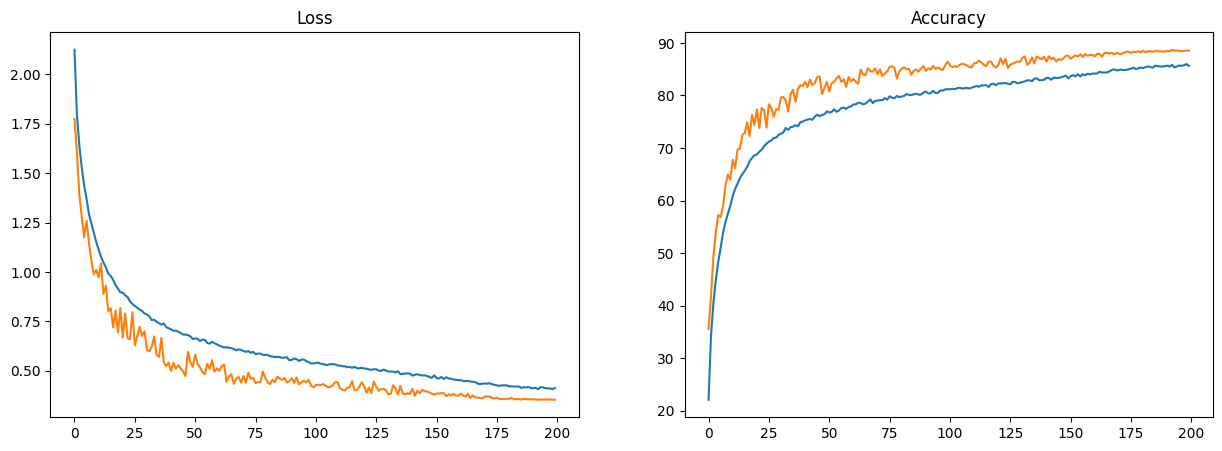

In [9]:
plot_curves(train_losses, train_acc, test_losses, test_acc)

In [13]:
model.eval()
transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize(mu, sigma)
                    ])
misclassified_images, misclassified_predictions, true_targets = [], [], []
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True)
with torch.no_grad():
    for data_, target in cifar_testset:
        data = transform(data_).to(device)
        data = data.unsqueeze(0)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)

        if pred.item()!=target:
            misclassified_images.append(data_)
            misclassified_predictions.append(pred.item())
            true_targets.append(target)

Files already downloaded and verified


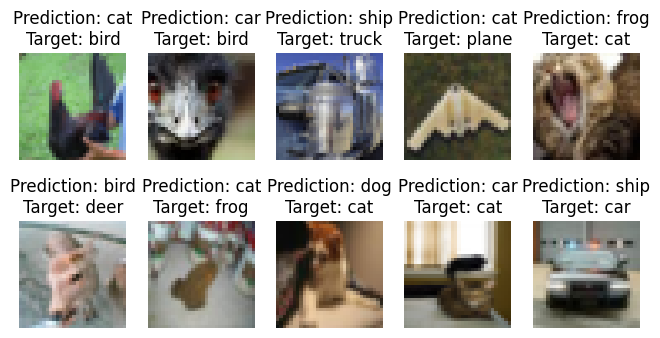

In [14]:
plot_misclassified(misclassified_images, misclassified_predictions, true_targets, classes)
plt.show()